# Test

## dataset generation

In [ ]:
import pandas as pd
import torch
from tqdm import tqdm
from torch_geometric.data import Data

def read_train_data(data: pd.DataFrame):
    training_dataset = []

    print(f'Reading training data.')
    for row in tqdm(data.itertuples()):
        try:
            training_dataset.append(torch.load(f'../polygraphpy/data/training_input_data/{row.id}_{row.chain_size}.pt', weights_only=False))
        except Exception as e:
            pass
    
    input_dim : int = training_dataset[0].x.shape[1] if training_dataset else 0

    return training_dataset, input_dim

def pad_graphs(dataset):
    max_nodes = max(data.x.shape[0] for data in dataset)
    feature_dim = dataset[0].x.shape[1]
    max_edges = max(data.edge_index.shape[1] for data in dataset)

    padded_dataset = []
    for data in dataset:
        num_nodes = data.x.shape[0]
        num_edges = data.edge_index.shape[1]

        x_padded = torch.zeros((max_nodes, feature_dim))
        x_padded[:num_nodes] = data.x

        edge_index_padded = torch.full((2, max_edges), fill_value=-1, dtype=torch.long)  # use -1 as invalid edge
        edge_index_padded[:, :num_edges] = data.edge_index

        node_mask = torch.zeros(max_nodes, dtype=torch.bool)
        node_mask[:num_nodes] = 1

        edge_mask = torch.zeros(max_edges, dtype=torch.bool)
        edge_mask[:num_edges] = 1

        padded_data = Data(
            x=x_padded,
            edge_index=edge_index_padded,
            y=getattr(data, 'y', None),
            node_mask=node_mask,
            edge_mask=edge_mask,
            id = getattr(data, 'mol_id', None),
            chain_size = getattr(data, 'chain_size', None),
        )

        padded_dataset.append(padded_data)

    return padded_dataset

def get_adjacency_matrix(edge_index: torch.Tensor, num_nodes: int, edge_mask: torch.Tensor = None):
    adj = torch.zeros((num_nodes, num_nodes), dtype=torch.float)

    if edge_mask is not None:
        edge_index = edge_index[:, edge_mask]

    valid = (edge_index[0] >= 0) & (edge_index[1] >= 0)
    edge_index = edge_index[:, valid]

    adj[edge_index[0], edge_index[1]] = 1.0

    return adj

df = pd.read_csv('../polygraphpy/data/polarizability_data.csv')
df = df[df['chain_size'] == 2]
training_dataset, NODE_FEATURE_DIM = read_train_data(df)
padded_dataset = pad_graphs(training_dataset)

node_size = [data.x.shape[0] for data in training_dataset]
max_node = max(node_size)
max_node_idx = node_size.index(max_node)

In [ ]:
import matplotlib.pyplot as plt

id = max_node_idx

df = pd.DataFrame()

for data in tqdm(padded_dataset):
    padded_data = data
    adj = get_adjacency_matrix(
        edge_index=padded_data.edge_index,
        num_nodes=padded_data.x.shape[0],
        edge_mask=getattr(padded_data, 'edge_mask', None)
    )
    x = padded_data.x.numpy()

    desired_width_pixels = adj.shape[0]
    desired_height_pixels = adj.shape[0]
    dpi = 100

    figsize_width = desired_width_pixels / dpi
    figsize_height = desired_height_pixels / dpi

    string = f'adj_{int(padded_data.id.numpy()[0])}_chainsize_{int(padded_data.chain_size.numpy()[0])}'
    y = padded_data.y.numpy()[0]

    df = pd.concat([df, pd.DataFrame({'string': string, 'polarizability': y}, index=[0])]).reset_index(drop=True)

    plt.figure(figsize=(figsize_width, figsize_height))
    plt.imshow(adj, cmap='Greys')
    plt.axis('off')
    plt.savefig(f'images/{string}.png', bbox_inches='tight', pad_inches=0, dpi=dpi)
    plt.close()

df.to_csv('input.csv', index=False)

## image generation

Input shape: torch.Size([8, 1, 64, 64])
Labels: tensor([21,  3, 24,  6,  2, 23,  8, 10])


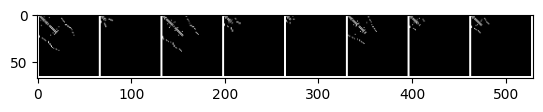

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import torchvision.transforms as transforms
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, image_dir, csv_file):
        self.image_dir = image_dir
        self.df = pd.read_csv(csv_file)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Pad((0, 0, 7, 7), fill=1, padding_mode='constant')
        ])
        self.discrete_labels = pd.cut(self.df['polarizability'], bins=25, labels=False)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['string'] + '.png'
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('L')
        image = self.transform(image)
        label = self.discrete_labels[idx]
        return image, torch.tensor(label, dtype=torch.long)
    
# Usage:
dataset = CustomDataset('images/', 'input.csv')

train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

In [54]:
dataset[0][1]

tensor(12)

In [4]:
class ClassConditionedUnet(nn.Module):
    def __init__(self, num_classes=25, class_emb_size=20):
        super().__init__()
        self.class_emb = nn.Embedding(num_classes, class_emb_size)
        self.model = UNet2DModel(
            sample_size=64,
            in_channels=1 + class_emb_size,
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(64, 128, 128, 256),
            down_block_types=("DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
            up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
        )

    def forward(self, x, t, class_labels):
        bs, ch, w, h = x.shape
        embed = self.class_emb(class_labels)
        class_cond = embed.view(bs, embed.shape[1], 1, 1).expand(bs, embed.shape[1], w, h)
        net_input = torch.cat((x, class_cond), 1)
        return self.model(net_input, t).sample

In [5]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

Using device: cuda


  0%|          | 0/460 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.015240


  0%|          | 0/460 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.010531


  0%|          | 0/460 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.009093


  0%|          | 0/460 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.009221


  0%|          | 0/460 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.008112


  0%|          | 0/460 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.006955


  0%|          | 0/460 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.006350


  0%|          | 0/460 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.006725


  0%|          | 0/460 [00:00<?, ?it/s]

Finished epoch 8. Average of the last 100 loss values: 0.006109


  0%|          | 0/460 [00:00<?, ?it/s]

Finished epoch 9. Average of the last 100 loss values: 0.006330


  0%|          | 0/460 [00:00<?, ?it/s]

Finished epoch 10. Average of the last 100 loss values: 0.005898


  0%|          | 0/460 [00:00<?, ?it/s]

Finished epoch 11. Average of the last 100 loss values: 0.005472


  0%|          | 0/460 [00:00<?, ?it/s]

Finished epoch 12. Average of the last 100 loss values: 0.005613


  0%|          | 0/460 [00:00<?, ?it/s]

Finished epoch 13. Average of the last 100 loss values: 0.005762


  0%|          | 0/460 [00:00<?, ?it/s]

Finished epoch 14. Average of the last 100 loss values: 0.005268


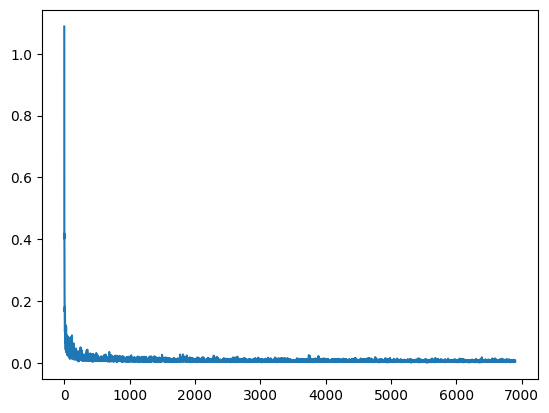

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
n_epochs = 15

net = ClassConditionedUnet().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []
aux = 1e9

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU (mapped to (0, 1))
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y)  # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise)  # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:]) / 100
    print(f"Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}")

    if avg_loss < aux:
        torch.save(net, 'diffusion_model.pt')
        aux = avg_loss

# View the loss curve
plt.plot(losses)

In [6]:
net = torch.load('diffusion_model.pt', weights_only=False)

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Prepare random x to start from, plus desired label y
x = torch.randn(1, 1, 64, 64).to(device)
y = torch.tensor([12]).to(device)  # Example class label (0-49)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = net(x, t, y)
    x = noise_scheduler.step(residual, t, x).prev_sample


Using device: cuda


0it [00:00, ?it/s]

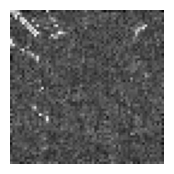

In [49]:
plt.figure(figsize=(2, 2))
plt.imshow(x.detach().cpu().clip(-1, 1).squeeze(), cmap="Greys")
plt.axis('off')
plt.show()

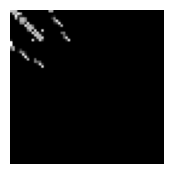

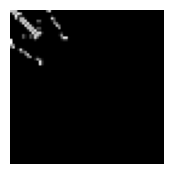

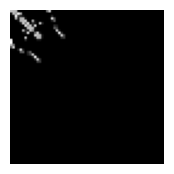

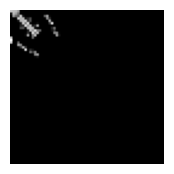

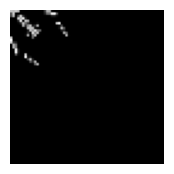

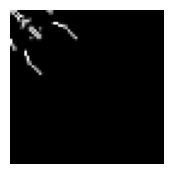

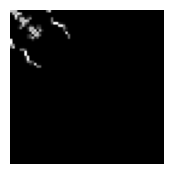

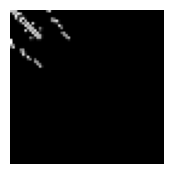

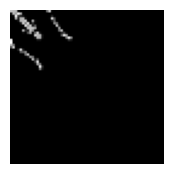

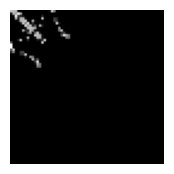

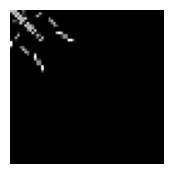

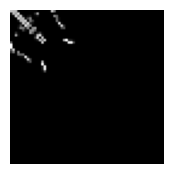

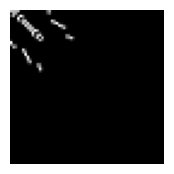

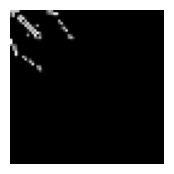

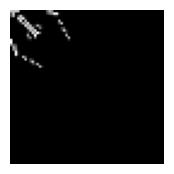

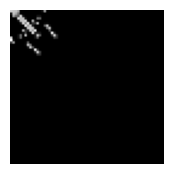

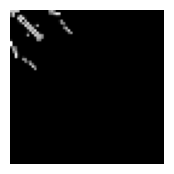

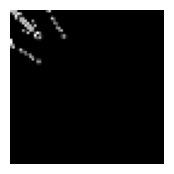

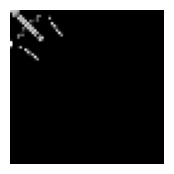

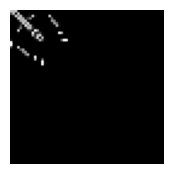

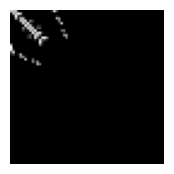

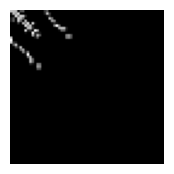

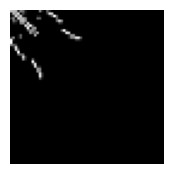

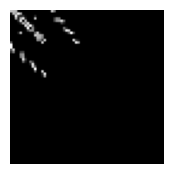

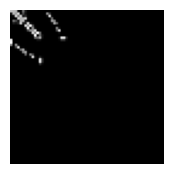

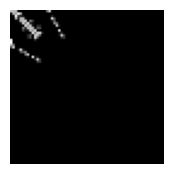

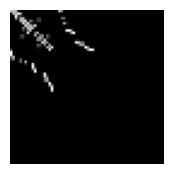

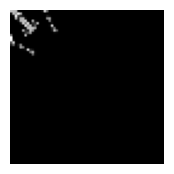

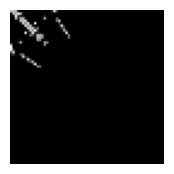

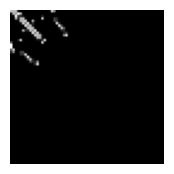

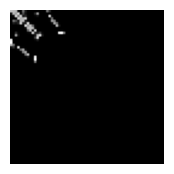

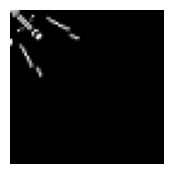

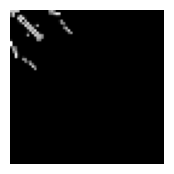

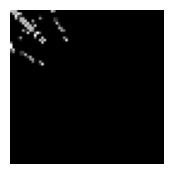

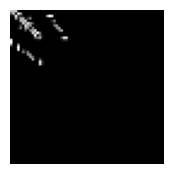

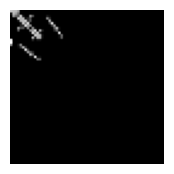

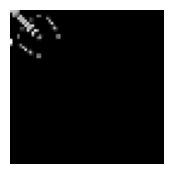

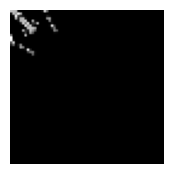

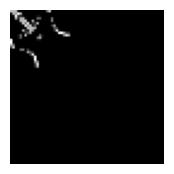

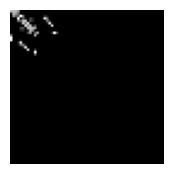

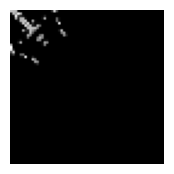

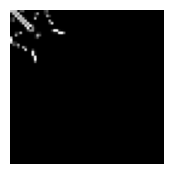

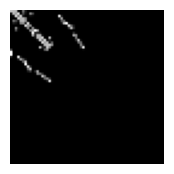

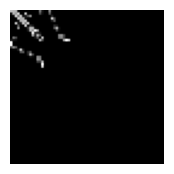

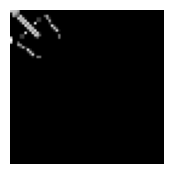

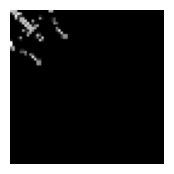

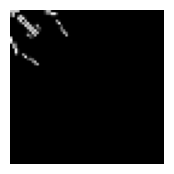

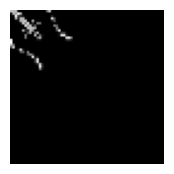

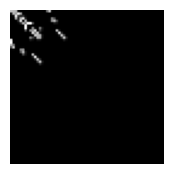

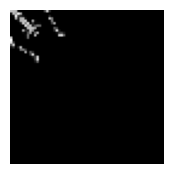

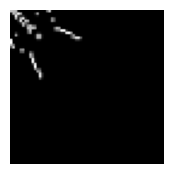

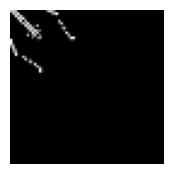

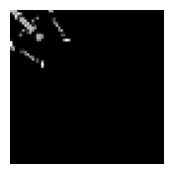

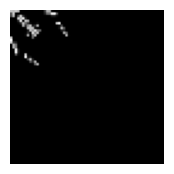

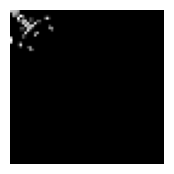

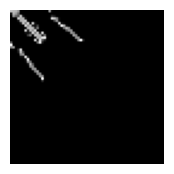

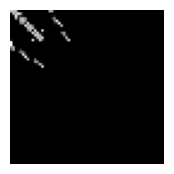

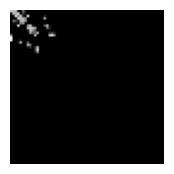

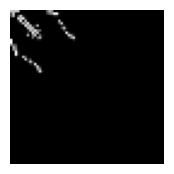

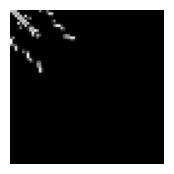

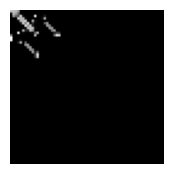

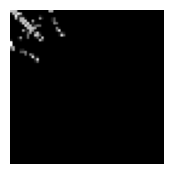

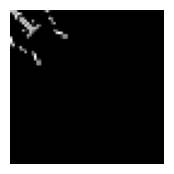

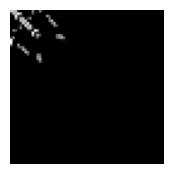

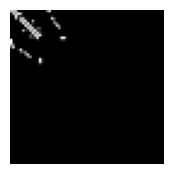

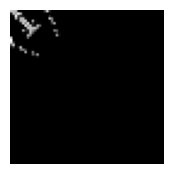

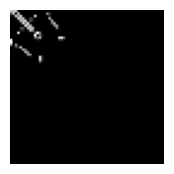

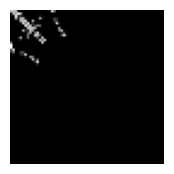

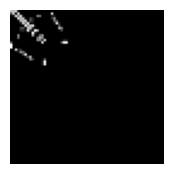

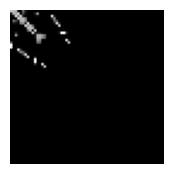

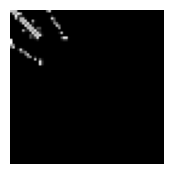

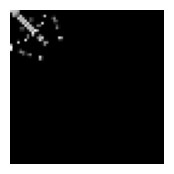

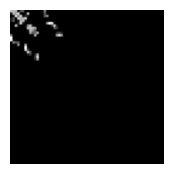

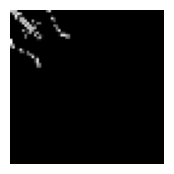

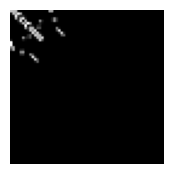

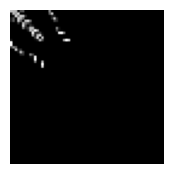

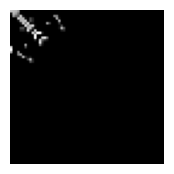

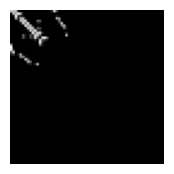

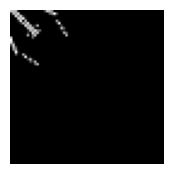

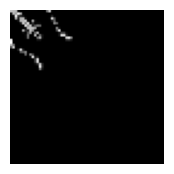

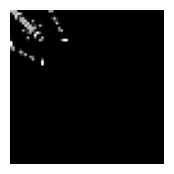

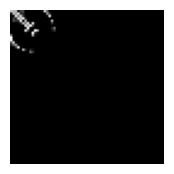

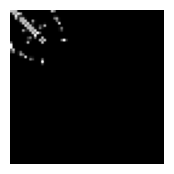

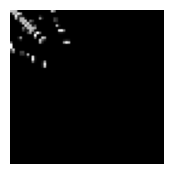

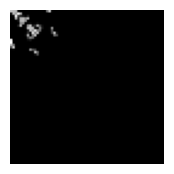

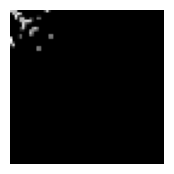

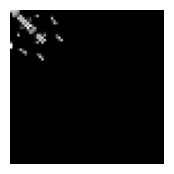

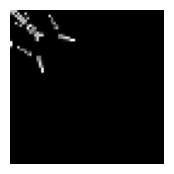

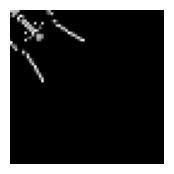

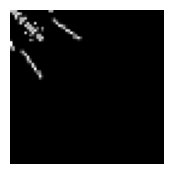

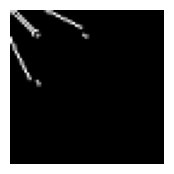

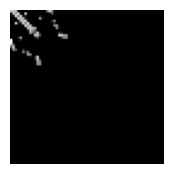

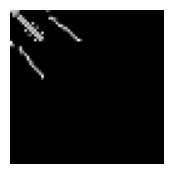

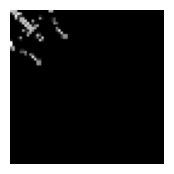

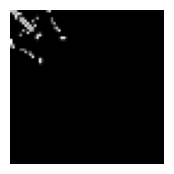

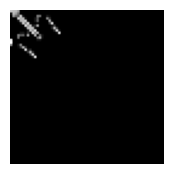

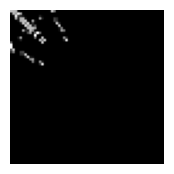

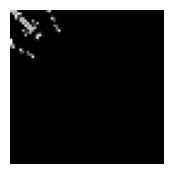

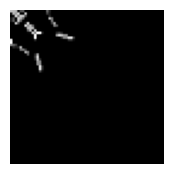

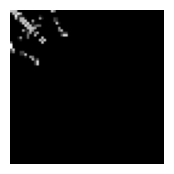

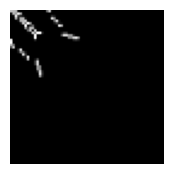

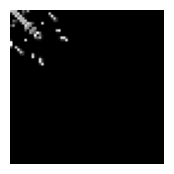

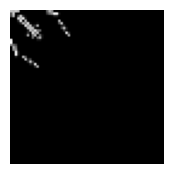

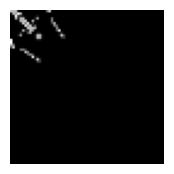

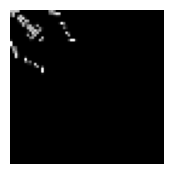

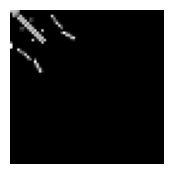

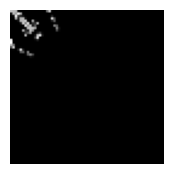

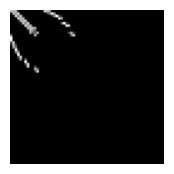

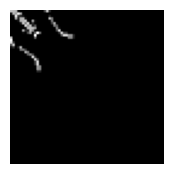

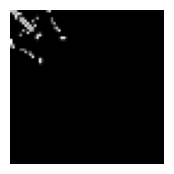

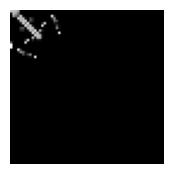

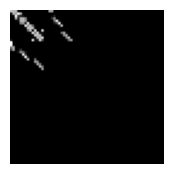

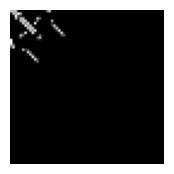

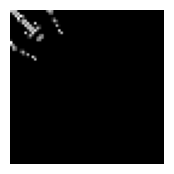

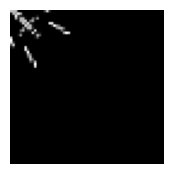

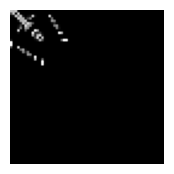

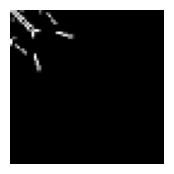

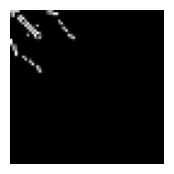

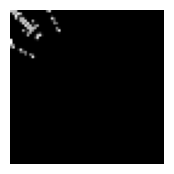

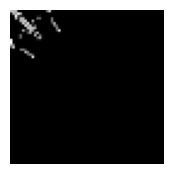

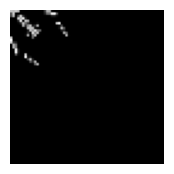

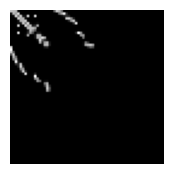

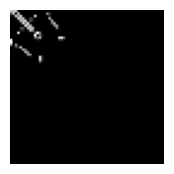

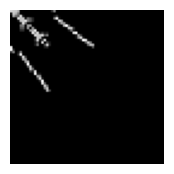

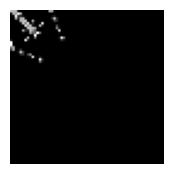

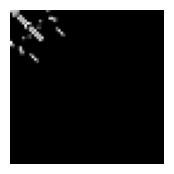

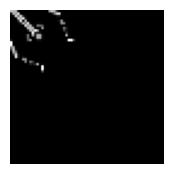

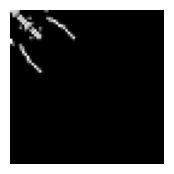

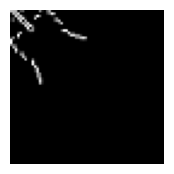

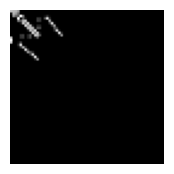

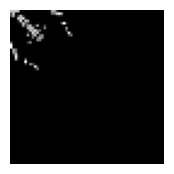

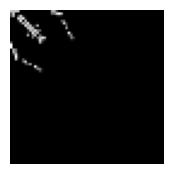

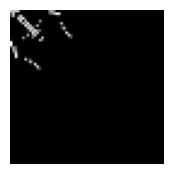

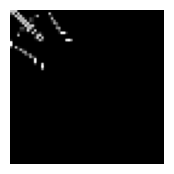

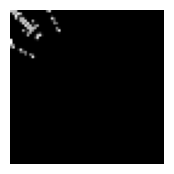

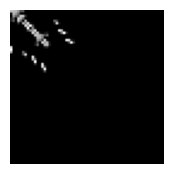

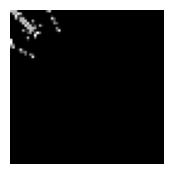

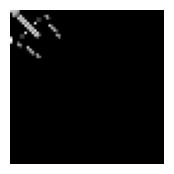

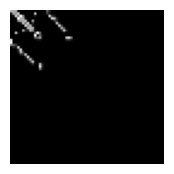

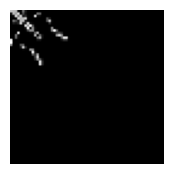

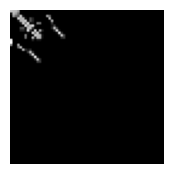

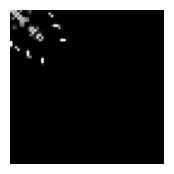

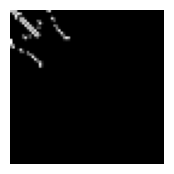

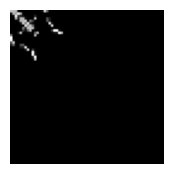

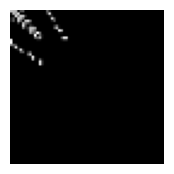

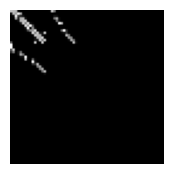

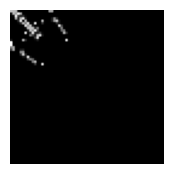

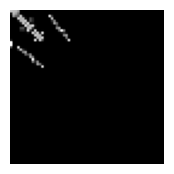

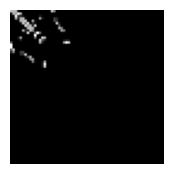

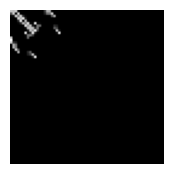

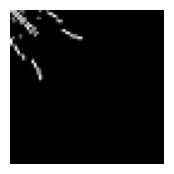

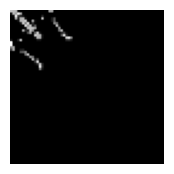

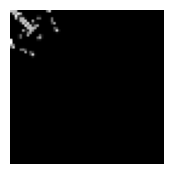

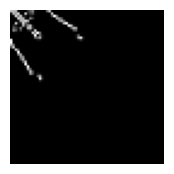

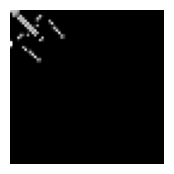

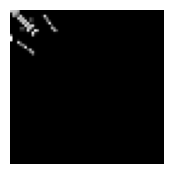

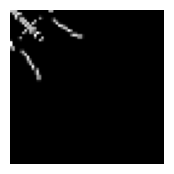

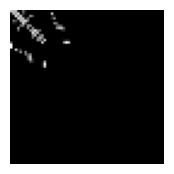

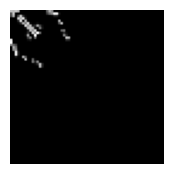

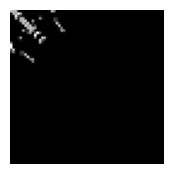

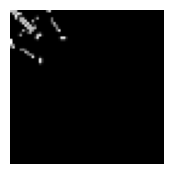

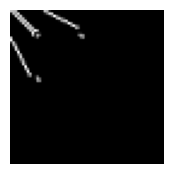

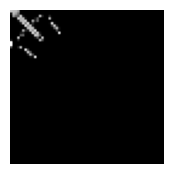

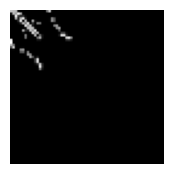

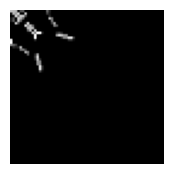

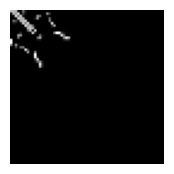

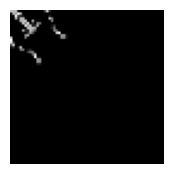

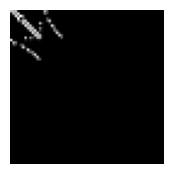

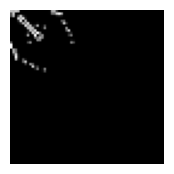

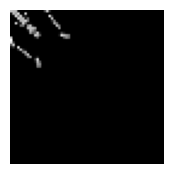

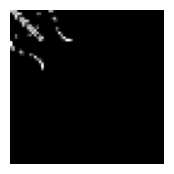

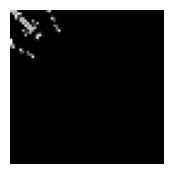

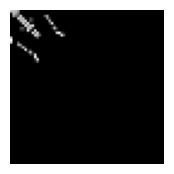

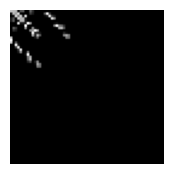

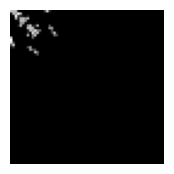

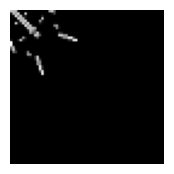

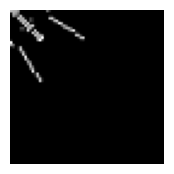

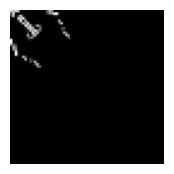

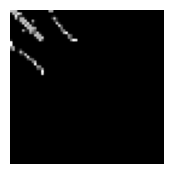

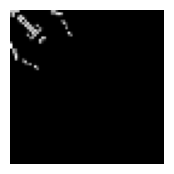

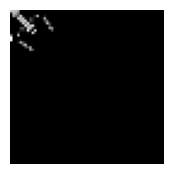

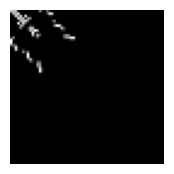

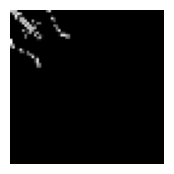

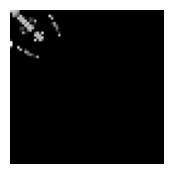

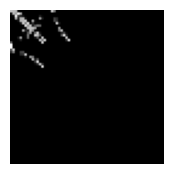

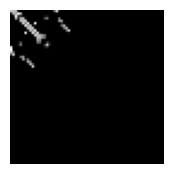

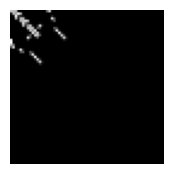

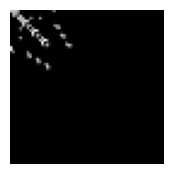

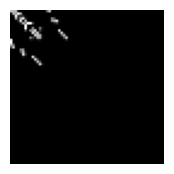

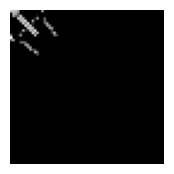

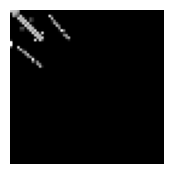

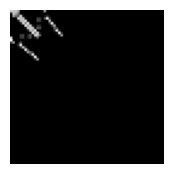

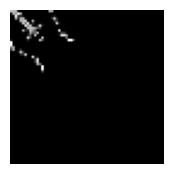

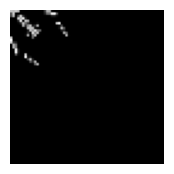

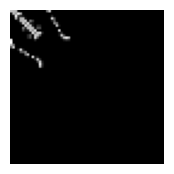

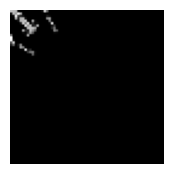

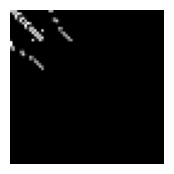

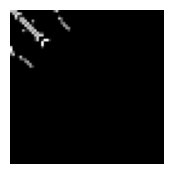

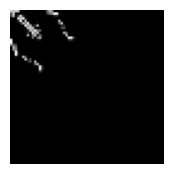

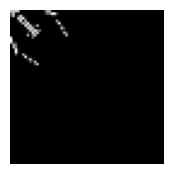

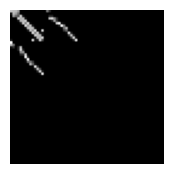

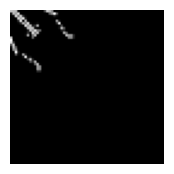

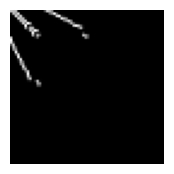

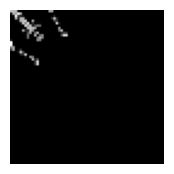

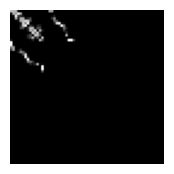

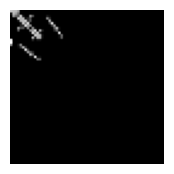

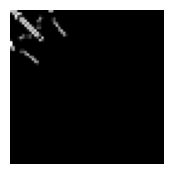

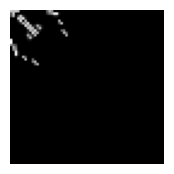

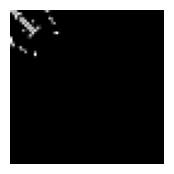

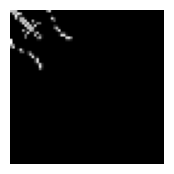

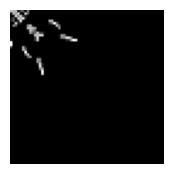

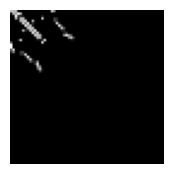

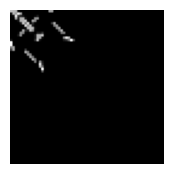

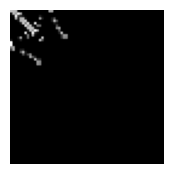

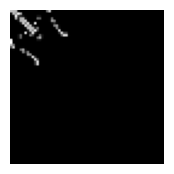

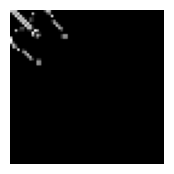

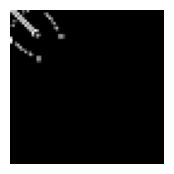

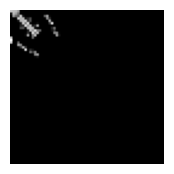

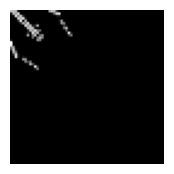

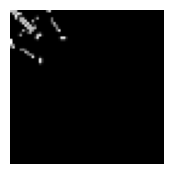

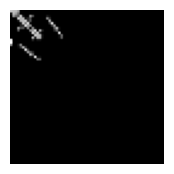

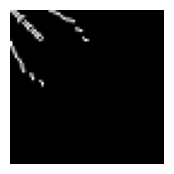

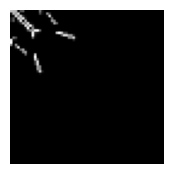

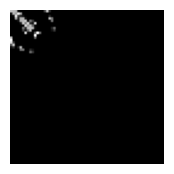

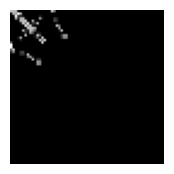

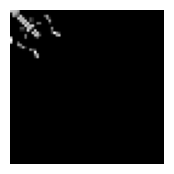

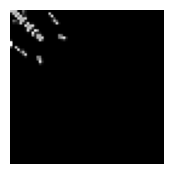

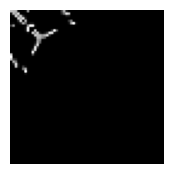

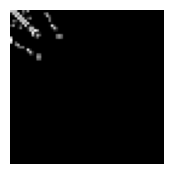

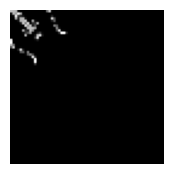

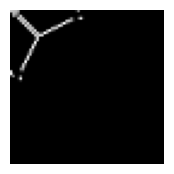

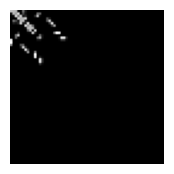

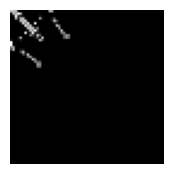

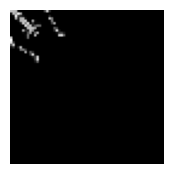

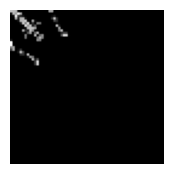

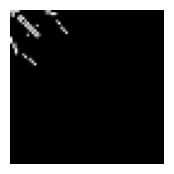

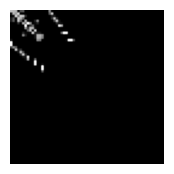

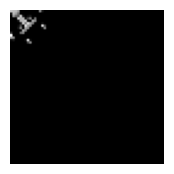

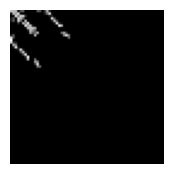

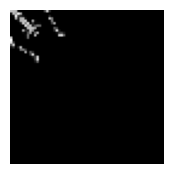

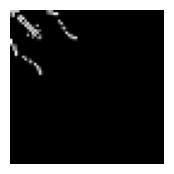

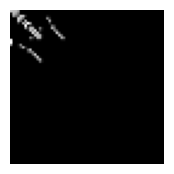

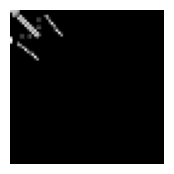

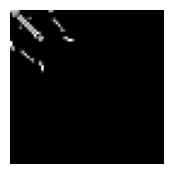

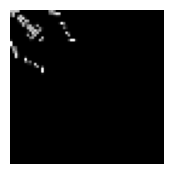

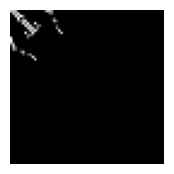

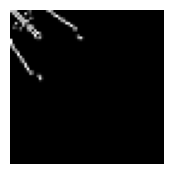

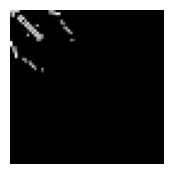

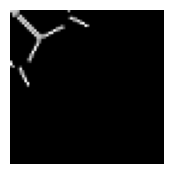

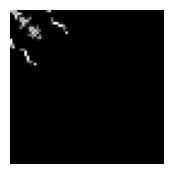

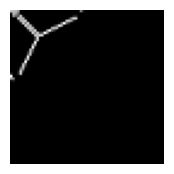

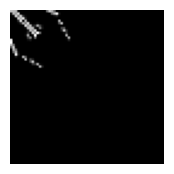

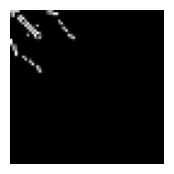

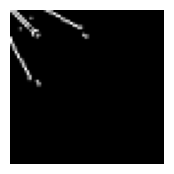

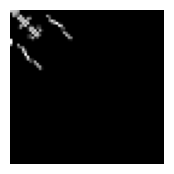

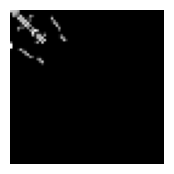

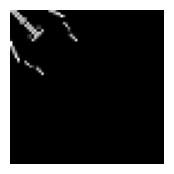

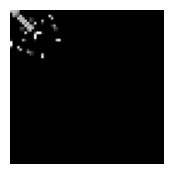

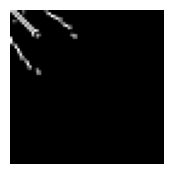

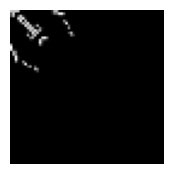

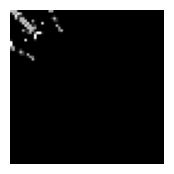

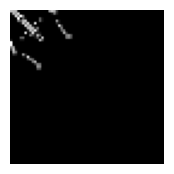

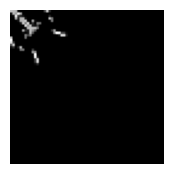

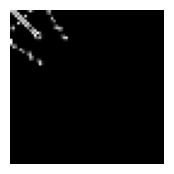

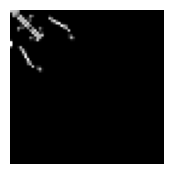

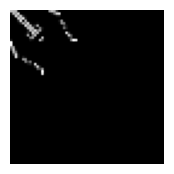

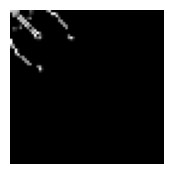

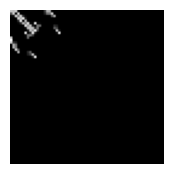

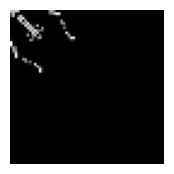

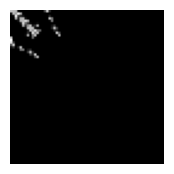

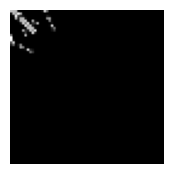

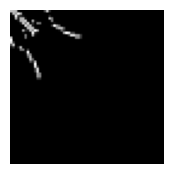

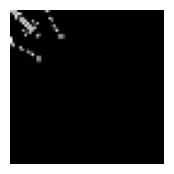

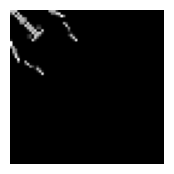

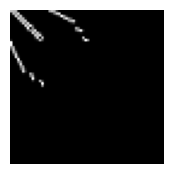

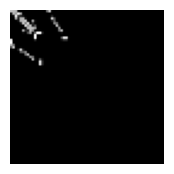

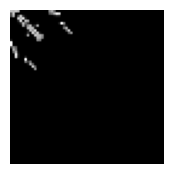

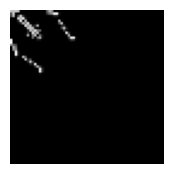

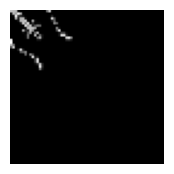

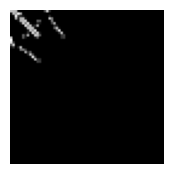

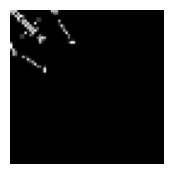

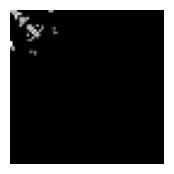

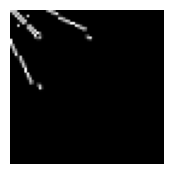

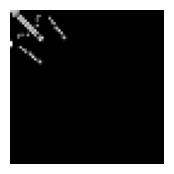

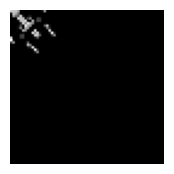

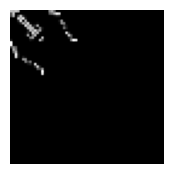

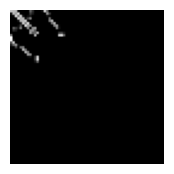

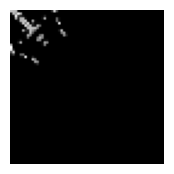

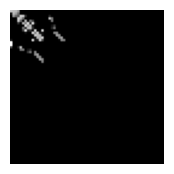

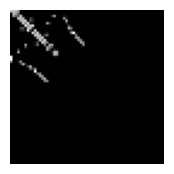

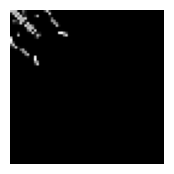

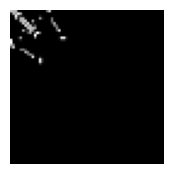

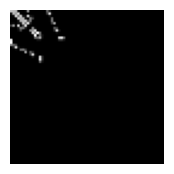

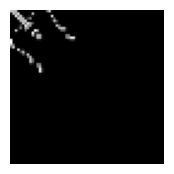

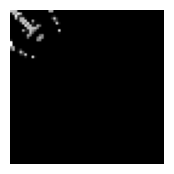

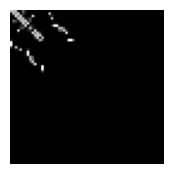

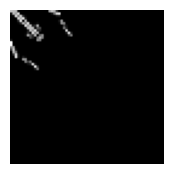

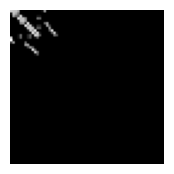

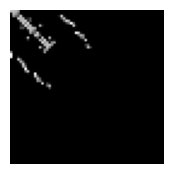

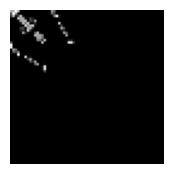

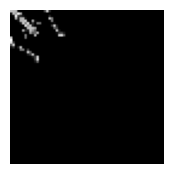

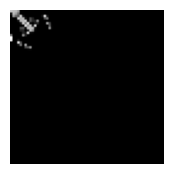

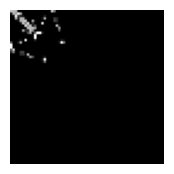

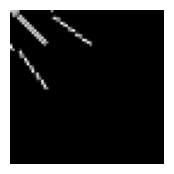

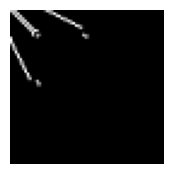

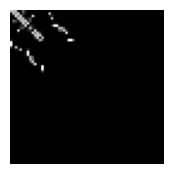

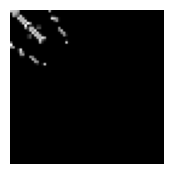

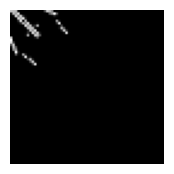

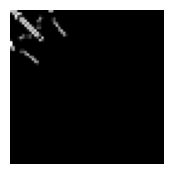

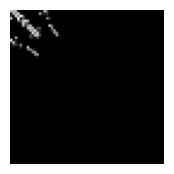

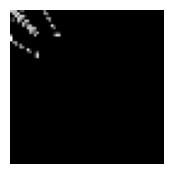

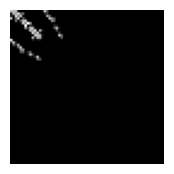

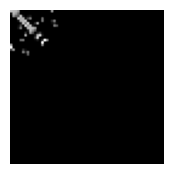

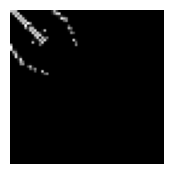

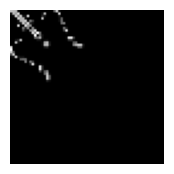

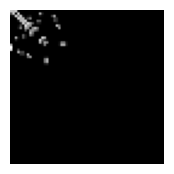

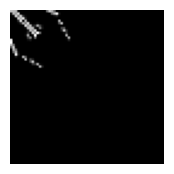

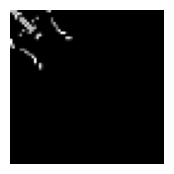

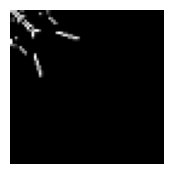

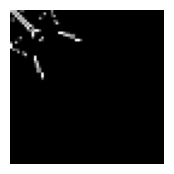

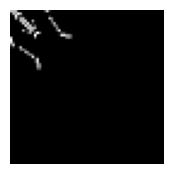

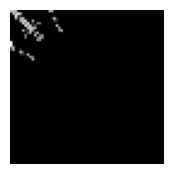

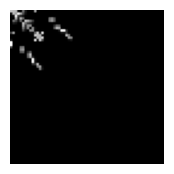

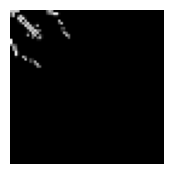

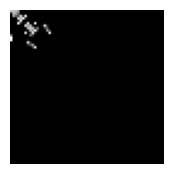

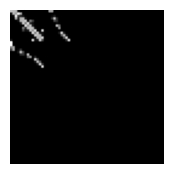

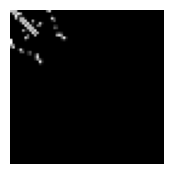

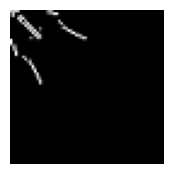

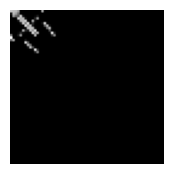

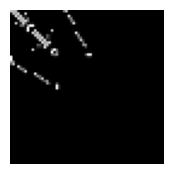

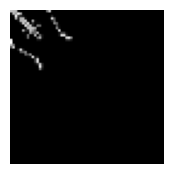

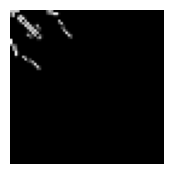

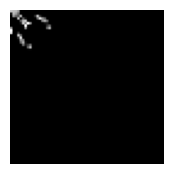

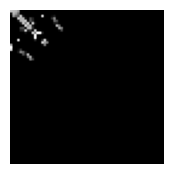

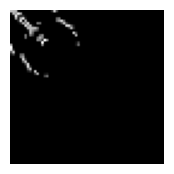

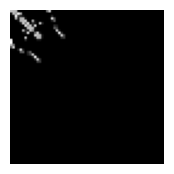

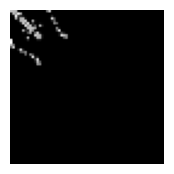

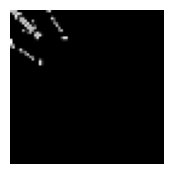

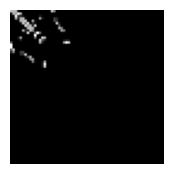

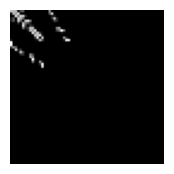

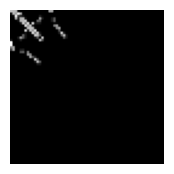

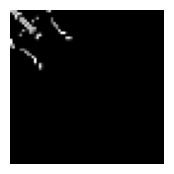

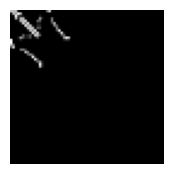

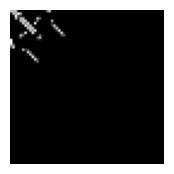

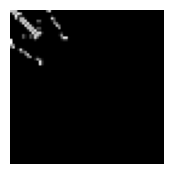

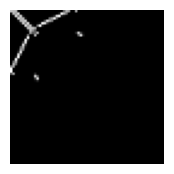

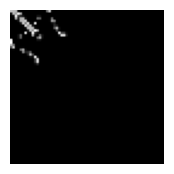

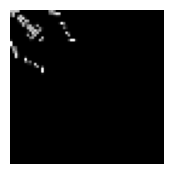

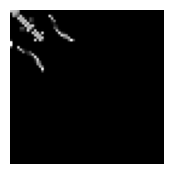

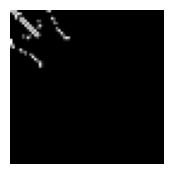

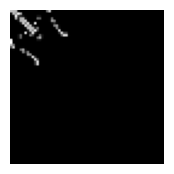

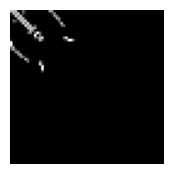

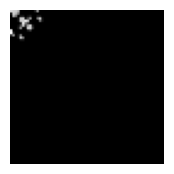

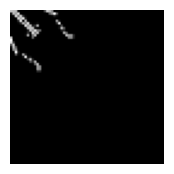

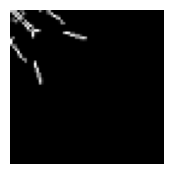

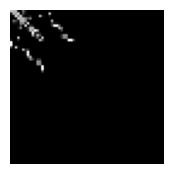

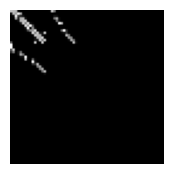

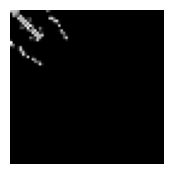

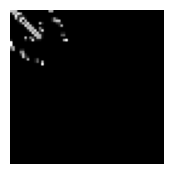

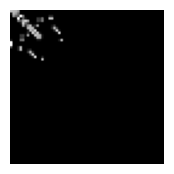

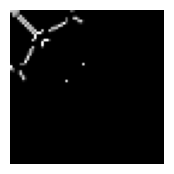

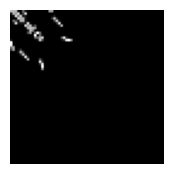

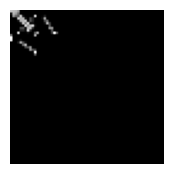

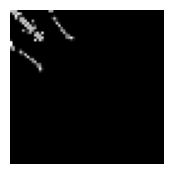

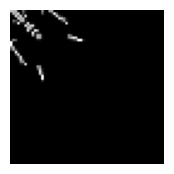

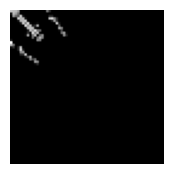

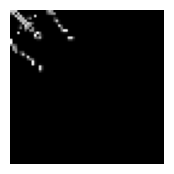

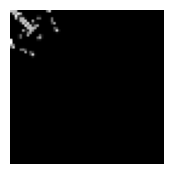

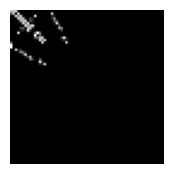

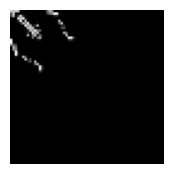

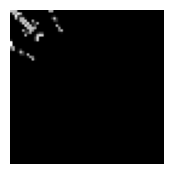

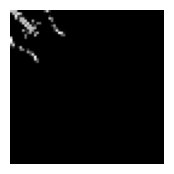

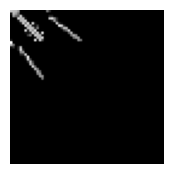

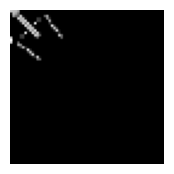

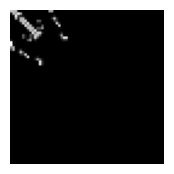

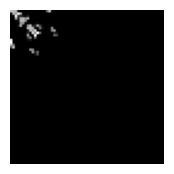

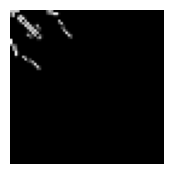

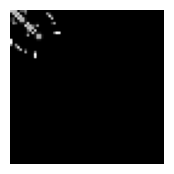

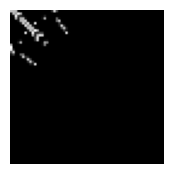

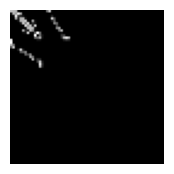

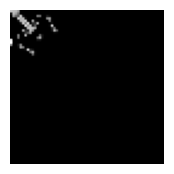

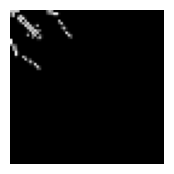

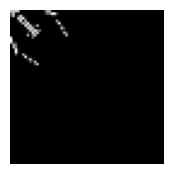

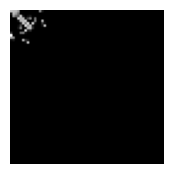

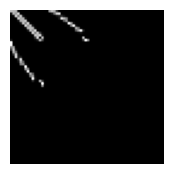

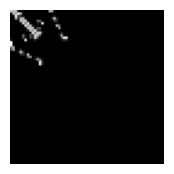

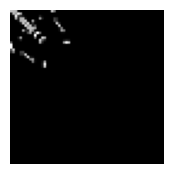

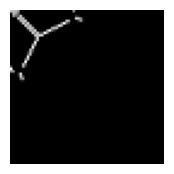

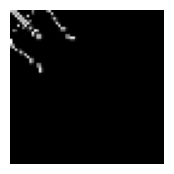

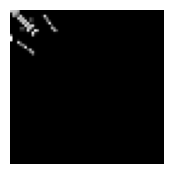

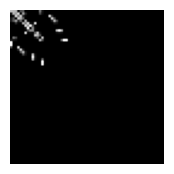

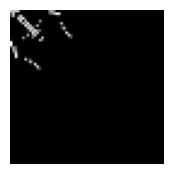

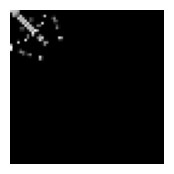

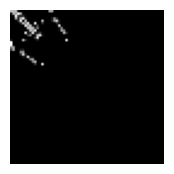

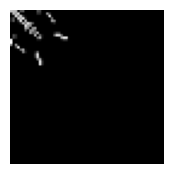

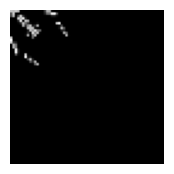

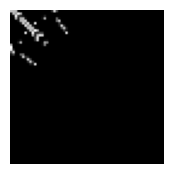

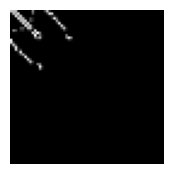

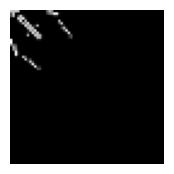

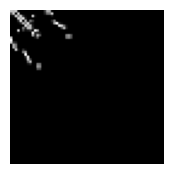

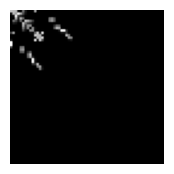

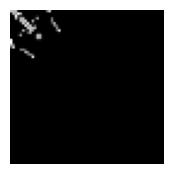

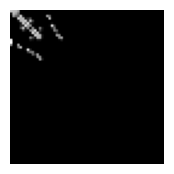

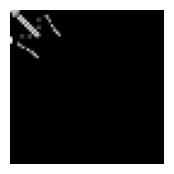

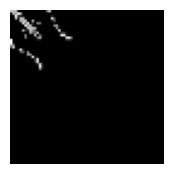

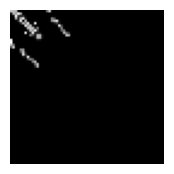

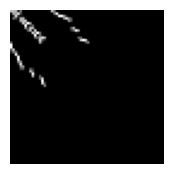

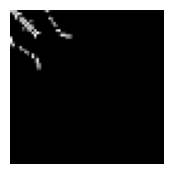

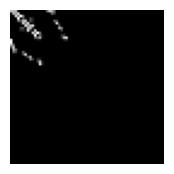

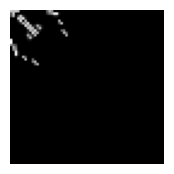

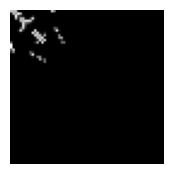

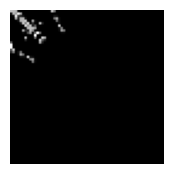

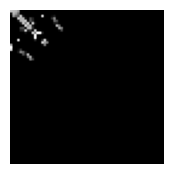

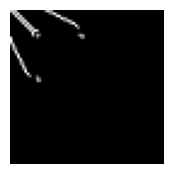

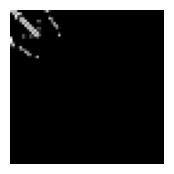

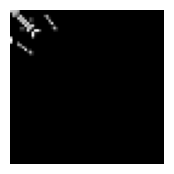

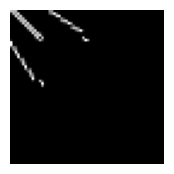

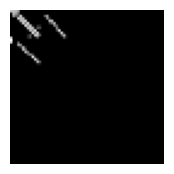

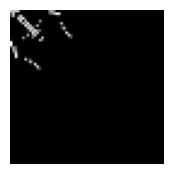

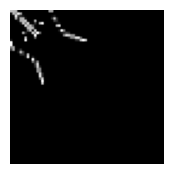

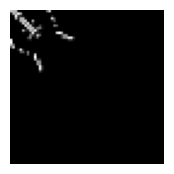

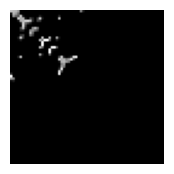

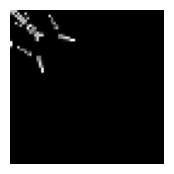

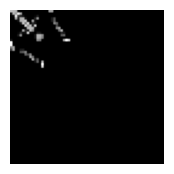

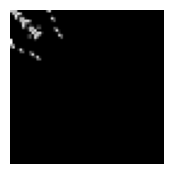

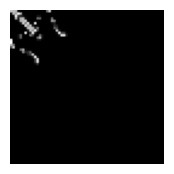

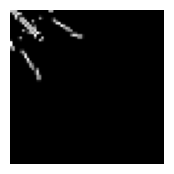

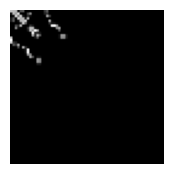

In [50]:
import matplotlib.pyplot as plt

for idx in range(len(dataset)):
    image, label = dataset[idx]
    if label.item() == 12:
        plt.figure(figsize=(2,2))
        plt.imshow(image.clip(-1, 1).squeeze(), cmap='Greys')
        plt.axis('off')
        plt.show()
        plt.close()